In [7]:
%matplotlib inline

In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 2

In [10]:
from pathlib import Path
import itertools 

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from matplotlib import rcParams

from scipy.spatial.distance import pdist, squareform

import numpy as np
import pandas as pd
import cmocean

import metpy
#import salem
import xarray as xr
#import rasterio as rio
#import rioxarray as rxr
import metpy
from metpy.interpolate import interpolate_to_grid

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import geopandas as gpd

import intro_plots as ip
from papercolors import colordict as pcd
import topology as tp 

paper_path = Path('../figures/')


rcParams['font.family'] = 'dejavu sans'
rcParams['figure.dpi'] = 200

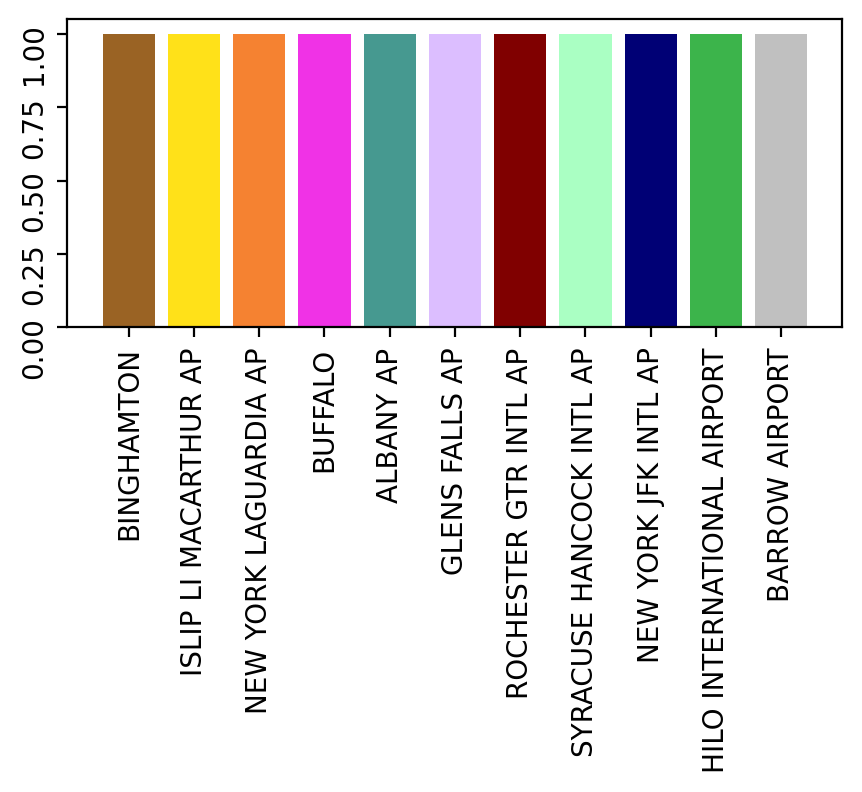

In [11]:
fig, ax = plt.subplots(figsize=(5,2))
ax.bar(ip.cdict.keys(), 1, color=ip.cdict.values())
ax.tick_params(rotation=90)

In [12]:
ny_all = pd.read_csv("nydata")

FileNotFoundError: [Errno 2] No such file or directory: 'nydata'

In [ ]:
ny = ny_all[ny_all['NAME'].isin(ip.ssubset)].copy().fillna(0)

ny['DATES'] = pd.to_datetime(ny['DATE'])

ny['TEMP (°F)'] = ny['TAVG'].apply(lambda x: f"{x:2.2f}")
ny['PRCP (in.)'] = ny['PRCPI'].apply(lambda x: f"{x:1.2f}")    

In [ ]:
ny['NAME'].unique()

In [ ]:
stations = ['NEW YORK LAGUARDIA AP', 'ALBANY AP', 'NEW YORK JFK INTL AP','ISLIP LI MACARTHUR AP', 'ROCHESTER GTR INTL AP']
date = '2021-01-01'
time_series = ny[ny['NAME'].isin(stations)]
time_series['DATE'] = pd.to_datetime(time_series['DATES'])
all_fields = ny[ny['NAME'].isin(stations)& (ny['DATE'] == date)].set_index('NAME').loc[stations].reset_index()
nyg = ny_all[ny_all['DATE']==date]
nygeo = gpd.GeoDataFrame(nyg, geometry=gpd.points_from_xy(nyg['LONGITUDE'], nyg['LATITUDE']), crs='EPSG:4269')
gdf = gpd.read_file('s_22mr22.zip')
nyshp = gdf[gdf['STATE'].str.match('NY')]

In [ ]:
px, py, prcp = interpolate_to_grid(nygeo['LONGITUDE'].values, nygeo['LATITUDE'].values, nygeo['PRCPI'].values, 
                                   interp_type='barnes', minimum_neighbors=3, 
                                         search_radius=.25, hres=.025, gamma=1)

In [ ]:
sample = all_fields[['NAME', 'TEMP (°F)','PRCP (in.)']]

In [ ]:
timeseries = {k:v.set_index('DATE') for k, v in time_series[['NAME','DATE', 'PRCPI']].groupby('NAME')}

In [ ]:
all_fields[['NAME', 'LATITUDE', 'LONGITUDE', 'TAVG']]

In [ ]:
mcolors.to_hex(cmocean.cm.rain(0))

In [ ]:
fig = plt.figure(figsize=(12,4), linewidth=2, constrained_layout=True)
fig0, fig1, fig2 = fig.subfigures(1,3)
for subfig in [fig0, fig1,fig2]:
    #fig0.frameon=True
    subfig.set_edgecolor('gray')
    subfig.set_linewidth(2)

axf0 = fig0.subplot_mosaic([['table'], ['k0']], gridspec_kw={'height_ratios':[2,1]})
tp.make_table(axf0['table'], axf0['k0'], sample)

axf1 = fig1.subplot_mosaic([['timeseries'],['k1']], gridspec_kw={'height_ratios':[2,1]})
tp.make_timeseries(axf1['timeseries'], axf1['k1'], timeseries)
axf1['timeseries'].set_title('Precipitation (in.)')

axf2 = fig2.subplot_mosaic([['map'], ['k2']], gridspec_kw={'height_ratios':[4,1]})


cmap = cmocean.cm.rain
nyshp.plot(ax=axf2['map'],  facecolor='#f6f5f7', edgecolor='none')
im = axf2['map'].pcolormesh(px, py, prcp, cmap=cmap)
nyshp.plot(ax=axf2['map'],  facecolor='none', edgecolor='k')
cb = fig.colorbar(im, ax=axf2['map'], fraction=.035)
cb.set_label("Precipitation (in.)")
axf2['map'].axis('off')
           
           
axf2['k2'].add_patch(mpatches.Rectangle((.25/2,.5-.25/2), .75, .75, color=pcd['base']))
axf2['k2'].set_aspect('equal')
axf2['k2'].axis('off')
fig.savefig(paper_path/'k_different_types.png')

In [ ]:
nygeo

In [ ]:
%conda install scipy